In [1]:
#Python libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import copy
from os import listdir
from pathlib import Path
from os.path import isfile, join
from tqdm import tqdm
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
from sklearn.model_selection import train_test_split

#Setting the global variables to be used across
count_n = 500 * 8
count_n_ = 1200 * 2
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [2]:
#create random places to remove the file pixels to simulate compressed sensing
def create(pp, img):
    img_ = np.zeros((8, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

    for i in range(len(img)):
        mask = np.random.choice([0, 1], size=(IMG_HEIGHT, IMG_WIDTH), p=[1-pp, pp])
        idx_w, idx_h = np.where(mask ==  1)

        for j in range(len(idx_w)):
            img[i, idx_w[j],idx_h[j],0] = 0

        img_[i,:,:,0] = img[i,:,:,0]
    return img_
    
def create_(pp, img):
    img_ = np.zeros((2, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

    for i in range(len(img)):
        mask = np.random.choice([0, 1], size=(IMG_HEIGHT, IMG_WIDTH), p=[1-pp, pp])
        idx_w, idx_h = np.where(mask ==  1)

        for j in range(len(idx_w)):
            img[i, idx_w[j],idx_h[j],0] = 0
            
        img_[i,:,:,0] = img[i,:,:,0]
    return img_

In [3]:
#Extract the images from the dataset
def curate(X_train, Y_train):
    data = Path('/content/drive/MyDrive/Datasets/csDataset/images')
    lst = [x for x in data.iterdir() if data.is_dir()]
    cnt = 0
  
    for idx, j in tqdm(enumerate(lst)):
        onlyfiles   = [f for f in listdir(lst[idx]) if isfile(join(lst[idx], f))]
        onlyfiles.remove('Thumbs.db')

        for _, i in enumerate(onlyfiles):
            p = join(str(lst[idx]),i)
            img = cv2.imread(p, 0)
            y_patches = image.extract_patches_2d(img, (IMG_HEIGHT, IMG_WIDTH), max_patches = 8)

            y_patches = np.reshape(y_patches,(8, IMG_HEIGHT, IMG_WIDTH,-1))

            y_patch = copy.deepcopy(y_patches)
            x_patches = create(0.75, y_patch)
            #print(x_patches.shape)
            for k in range(len(x_patches)):
                X_train[cnt] = x_patches[k]
                Y_train[cnt] = y_patches[k]
                cnt += 1

    return X_train, Y_train

In [4]:
def curate_new(X_train, Y_train):
  data = Path('/content/drive/MyDrive/Datasets/csDataset/Linnaeus256by256/train')
  lst = [x for x in data.iterdir() if data.is_dir()]
  cnt = 0

  for idx, j in tqdm(enumerate(lst)):
    onlyfiles   = [f for f in listdir(lst[idx]) if isfile(join(lst[idx], f))]
    
    for _, i in enumerate(onlyfiles):
      p = join(str(lst[idx]),i)
      img = cv2.imread(p, 0)
      y_patches = image.extract_patches_2d(img, (IMG_HEIGHT, IMG_WIDTH), max_patches = 2)

      y_patches = np.reshape(y_patches,(2, IMG_HEIGHT, IMG_WIDTH,-1))


      y_patch = copy.deepcopy(y_patches)
      x_patches = create_(0.75, y_patch)
      
      for k in range(len(x_patches)):
        X_train[cnt] = x_patches[k]
        Y_train[cnt] = y_patches[k]
        cnt += 1

    return X_train, Y_train

#create dataset for images
########################## CREATE DATASET #############################
X_train_ = np.zeros((count_n_, 128, 128, 1), dtype=np.uint8)
Y_train_ = np.zeros((count_n_, 128, 128, 1), dtype=np.uint8)
#######################################################################

X_, Y_ = curate_new(X_train_, Y_train_)

X_ = X_ / 255.
Y_ = Y_ / 255.



0it [00:00, ?it/s]

In [5]:
#print the images for testing
def printResult(X, Y):
    fig = plt.figure(figsize=(9, 4))
    columns = 10
    rows = 1
    for i in range(1, columns*rows + 1):
        img_x = X[i-1]
        ax = fig.add_subplot(rows, columns, i)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img_x, cmap = 'gray')
    plt.show()
    return None

In [6]:
def psnr_mean(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def networkCSNet(x_train, y_train, x_val, y_val):

    input_layer = tf.keras.layers.Input((128, 128, 1))

    conv1 = tf.keras.layers.Conv2D(12, (3,3), padding='same')(input_layer)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(12, (3,3), padding='same')(conv1)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(12, (3,3), padding='same')(conv2)
    conv3 = tf.keras.layers.ReLU()(conv3)

    conv4 = tf.keras.layers.Conv2D(12, (3,3), padding='same')(conv3)
    conv4 = tf.keras.layers.ReLU()(conv4)

    conv5 = tf.keras.layers.Conv2D(12, (3,3), padding='same')(conv4)
    conv5 = tf.keras.layers.ReLU()(conv5)
    
    conv6 = tf.keras.layers.Conv2D(12, (3,3), padding='same')(conv5)
    conv6 = tf.keras.layers.ReLU()(conv6)

    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(conv6)

    ae = tf.keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    ae.compile(optimizer='adam', loss=ssim_loss, metrics=[psnr_mean])

    ae.summary()
    checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Datasets/csDataset/results/cs-1000.h5', verbose=0, save_best_only=True)
    history = ae.fit(x_train, y_train, epochs=1000, batch_size=8, shuffle=True, validation_data=(x_val, y_val), verbose = 0,  callbacks=[checkpointer])

    hist_df = pd.DataFrame(history.history)
    hist_csv_file = '/content/drive/MyDrive/Datasets/csDataset/results/cs-history-1000.csv'

    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)

    print('End of training ...')
    return ae

In [7]:
def networkCSNet_unet(x_train, y_train, x_val, y_val):

    input_layer = tf.keras.layers.Input((128, 128, 1))

    conv1 = tf.keras.layers.Conv2D(8, (3,3), padding='same')(input_layer)
    #conv1 = tf.keras.layers.MaxPool2D((2,2))(conv1)
    conv1 = tf.keras.layers.ReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(8, (3,3), padding='same')(conv1)
    #conv1 = tf.keras.layers.MaxPool2D((2,2))(conv2)
    conv2 = tf.keras.layers.ReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(8, (3,3), padding='same')(conv2)
    #conv1 = tf.keras.layers.MaxPool2D((2,2))(conv3)
    conv3 = tf.keras.layers.ReLU()(conv3)

    conv4 = tf.keras.layers.Conv2DTranspose(8, (3,3), padding='same')(conv3)
    conv4 = tf.keras.layers.ReLU()(conv4)

    conv5 = tf.keras.layers.Conv2DTranspose(8, (3,3), padding='same')(conv4)
    conv5 = tf.keras.layers.ReLU()(conv5)
    
    conv6 = tf.keras.layers.Conv2DTranspose(8, (3,3), padding='same')(conv5)
    conv6 = tf.keras.layers.ReLU()(conv6)

    
    #conv7 = tf.keras.layers.Conv2D(3, (3,3), padding='same')(conv6)
    #conv7 = tf.keras.layers.ReLU()(conv7)

    output_layer = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(conv6)

    ae = tf.keras.models.Model(inputs = [input_layer], outputs = [output_layer])
    ae.compile(optimizer='adam', loss=ssim_loss, metrics=[psnr_mean])

    ae.summary()
    checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-1000.h5', verbose=1, save_best_only=True)
    history = ae.fit(x_train, y_train, epochs=1000, batch_size=8, shuffle=True, validation_data=(x_val, y_val), verbose = 1,  callbacks=[checkpointer])

    hist_df = pd.DataFrame(history.history)
    hist_csv_file = '/content/drive/MyDrive/Datasets/csDataset/results/cs-unet-history-1000.csv'

    with open(hist_csv_file, mode = 'w') as f:
        hist_df.to_csv(f)

    print('End of training ...')
    return ae

In [8]:
#create dataset for images
########################## CREATE DATASET #############################
X_train = np.zeros((count_n, 128, 128, 1), dtype=np.uint8)
Y_train = np.zeros((count_n, 128, 128, 1), dtype=np.uint8)
#######################################################################
#Get the curated data from the dataset
X, Y = curate(X_train, Y_train)

X = X / 255.
Y = Y / 255.




0it [00:00, ?it/s]
1it [01:55, 115.73s/it]
2it [02:50, 97.43s/it] 
3it [04:31, 90.39s/it]


In [9]:
X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(np.concatenate((X,X_),axis=0), np.concatenate((Y,Y_),axis=0), test_size = 0.2, random_state = 42)
model_cnn = networkCSNet(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL)
#model_cnn = networkCSNet_unet(X_TRAIN, Y_TRAIN, X_VAL, Y_VAL)
#model_cnn = networkCSNet(train_test_split(np.concatenate((X,X_),axis=0), np.concatenate((Y,Y_),axis=0), test_size = 0.2, random_state = 42))
predict = model_cnn.predict(X_VAL[:10,:,:,:])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 6)       60        
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       440       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 12)      876       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 128, 12)      0     

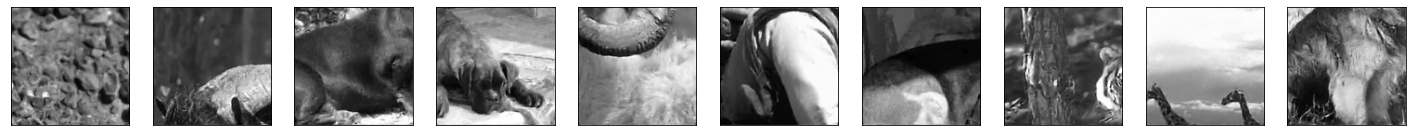

In [10]:
predict = model_cnn.predict(X_VAL[:10,:,:,:])
fig = plt.figure(figsize=(25, 25))
columns = 10
rows = 1
for i in range(1, columns*rows + 1):
  img_x = predict[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

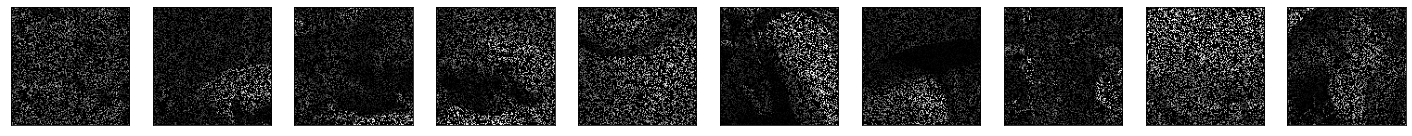

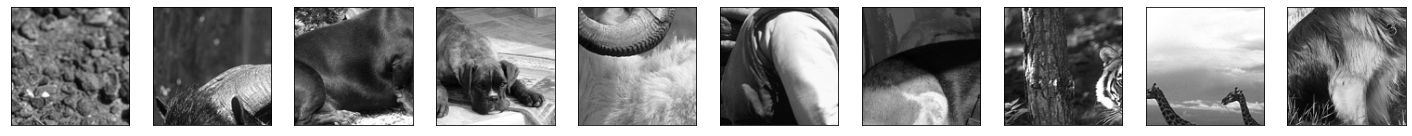

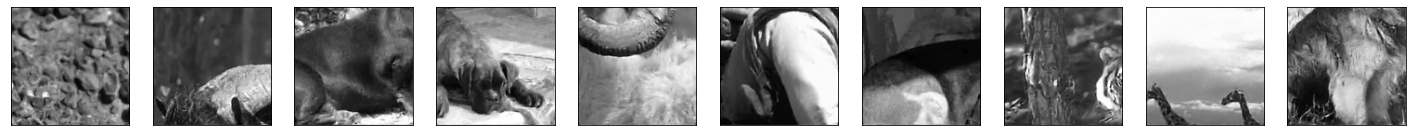

In [11]:
#predict = model_cnn.predict(X_VAL[:10,:,:,:])
predict_x = X_VAL[:10,:,:,:]
predict_y = Y_VAL[:10,:,:,:]
fig = plt.figure(figsize=(25, 25))
columns = 10
rows = 1
for i in range(1, columns*rows + 1):
  img_x = predict_x[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

fig = plt.figure(figsize=(25, 25))
for i in range(1, columns*rows + 1):
  img_x = predict_y[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

predict = model_cnn.predict(X_VAL[:10,:,:,:])
fig = plt.figure(figsize=(25, 25))
columns = 10
rows = 1
for i in range(1, columns*rows + 1):
  img_x = predict[i-1]
  ax = fig.add_subplot(rows, columns, i)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.reshape(img_x,(128,128)),cmap='gray')
plt.show()

In [12]:
psnr2 = tf.image.psnr(Y_VAL[:10,:,:,:], predict, max_val=1.0)
print(psnr2)
print(tf.reduce_mean(psnr2))

tf.Tensor(
[27.098019 26.85607  26.036596 26.363625 27.706312 28.80265  31.421398
 23.809011 30.092955 23.990461], shape=(10,), dtype=float32)
tf.Tensor(27.217709, shape=(), dtype=float32)


In [17]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Datasets/csDataset/results/cs-history-300.csv', sep=',',header=None)

In [18]:
df.head()

loss = df[1]
val_loss = df[3]

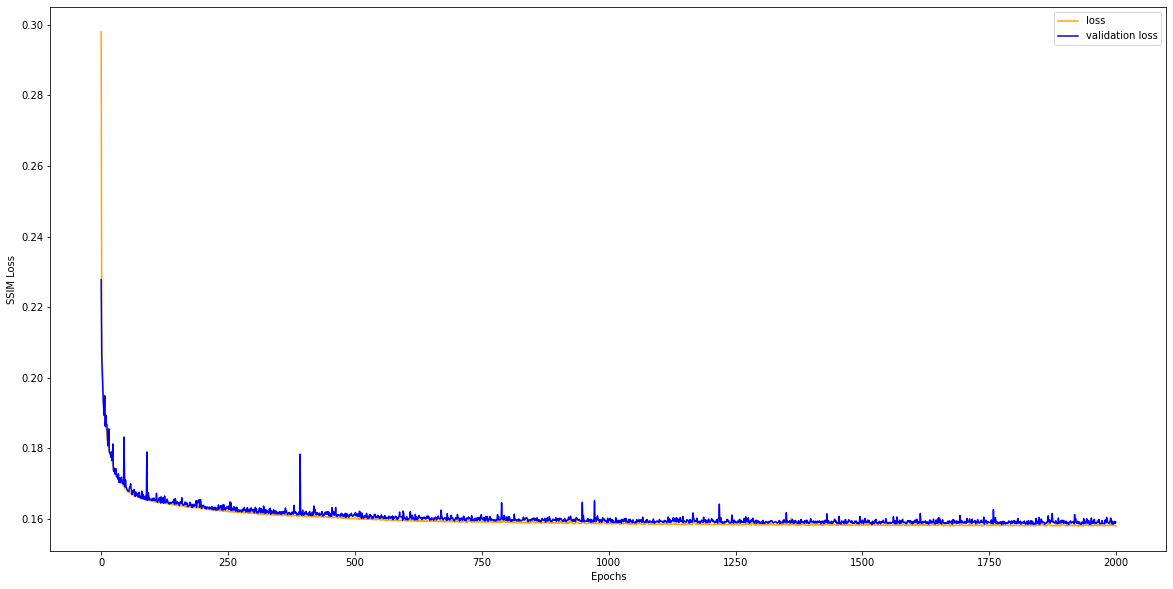

In [19]:
plt.figure(figsize=(20,10))
plt.plot(loss.values[1:].astype(np.float32),color='orange')
plt.plot(val_loss.values[1:].astype(np.float32),color='blue')
plt.legend(['loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('SSIM Loss')
plt.show()

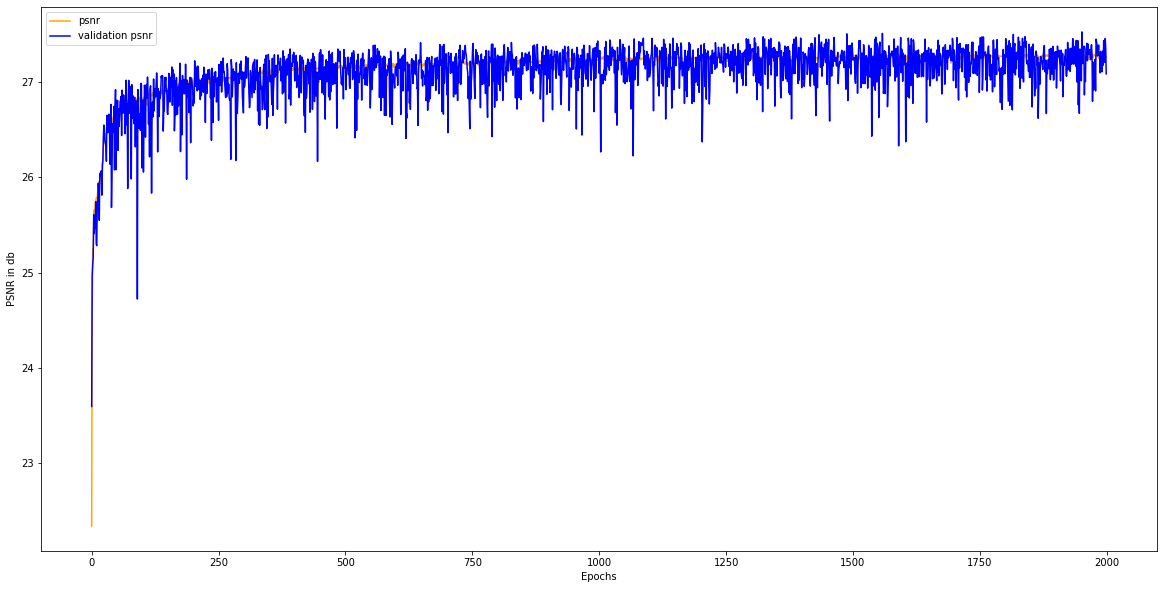

In [20]:
df.head()

psnr = df[2]
val_psnr = df[4]

plt.figure(figsize=(20,10))
plt.plot(psnr.values[1:].astype(np.float32),color='orange')
plt.plot(val_psnr.values[1:].astype(np.float32),color='blue')
plt.legend(['psnr','validation psnr'])
plt.xlabel('Epochs')
plt.ylabel('PSNR in db')
plt.show()

In [ ]:
'/content/drive/MyDrive/Datasets/csDataset/test_images'